#0. Prerequisites

In [253]:
#Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path

In [254]:
#Setup
sns.set_style("whitegrid")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [255]:
#Superglobals
WINDOW_SIZE = 31

In [256]:
#Loading the data
df = pd.read_csv('https://raw.githubusercontent.com/subtle64/Datasets/main/Kaggle/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


#1. Data Preprocessing and Exploration

In [257]:
#Testing for NAs
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [258]:
#Testing for Duplications
df.duplicated().sum()

0

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [260]:
df.Date = pd.to_datetime(df.Date)

<Axes: >

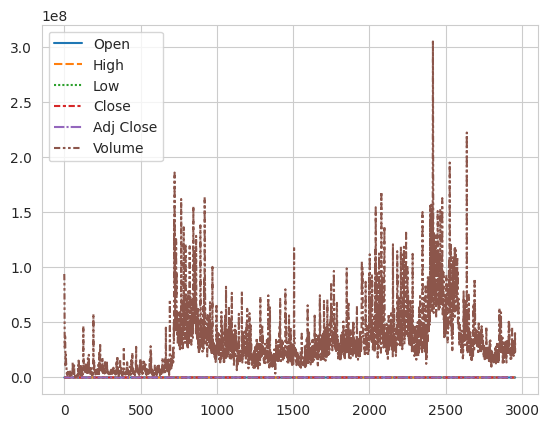

In [261]:
sns.lineplot(df)

<Axes: xlabel='Date', ylabel='value'>

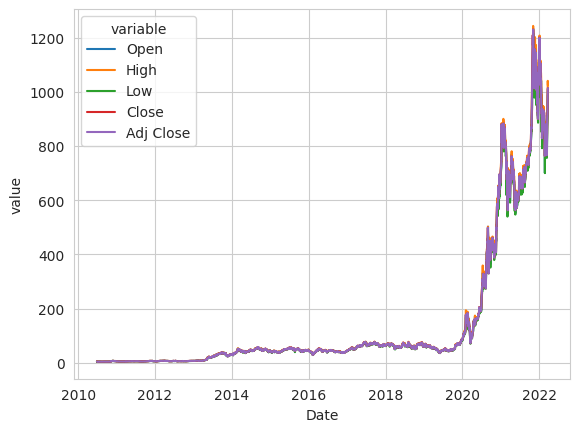

In [262]:
sns.lineplot(x = 'Date', y = 'value', hue = 'variable', data=pd.melt(df.drop("Volume", axis = 1), ['Date']))

Almost all measurements are similar, except Volume, since we are going
to predict the stock prices, it's best to use the 'Adj Close' column since it is the final stock price compensating any company actions on that date

In [263]:
df_used = df[['Adj Close']]
df_used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2956 non-null   float64
dtypes: float64(1)
memory usage: 23.2 KB


#2. RNN Modelling

In [264]:
#Splitting the Data
#80% Train 20% Testing
split_index = int(len(df_used) - 0.20*len(df_used))
df_train = df_used[:split_index]
df_val = df_used[split_index - WINDOW_SIZE:]
print(f"Training: {len(df_train)}, Testing: {len(df_val)}")

Training: 2364, Testing: 623


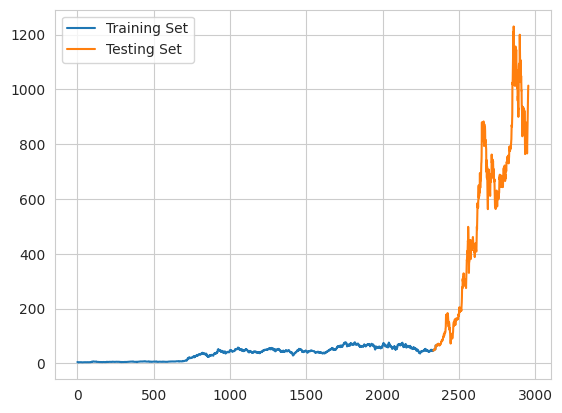

In [265]:
#It would be interesting to see if an RNN could predict such ridiculous changes
df_train['Adj Close'].plot(legend = True)
df_val['Adj Close'].plot(legend = True)
plt.legend(['Training Set', 'Testing Set'])

In [266]:
#Scale the data to desensitize the RNN model to insane changes, but predict patterns instead
#Obviously using the Standard Scaler on non-normal data is a bad idea
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_train), columns = ['Adj Close'])

In [267]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2364 entries, 0 to 2363
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2364 non-null   float64
dtypes: float64(1)
memory usage: 18.6 KB


In [274]:
#Creating a 1-month datset window to train the RNNs
def generate_windows(df):
  x = []
  y = []
  for i in range(WINDOW_SIZE, len(df)):
    x.append(df.iloc[i - WINDOW_SIZE:i, 0])
    y.append(df.iloc[i, 0])
  return (np.array(x), np.array(y))

In [275]:
x_train, y_train = generate_windows(df_scaled)
print(x_train.shape, y_train.shape)
print(y_train)

(2333, 31) (2333,)
[0.00487541 0.00682557 0.00807151 ... 0.89466414 0.90343991 0.91107798]


In [276]:
from tensorflow import keras
from keras import layers

#Input Shape
INPUT_SHAPE = (WINDOW_SIZE, 1)

#Defining the RNN model
inputs = keras.Input(INPUT_SHAPE)

#First LSTM Block
block1 = layers.LSTM(64, return_sequences = True)(inputs)

#Second LSTM Block
block2 = layers.LSTM(64, return_sequences = True)(block1)

#Third LSTM Block
block3 = layers.LSTM(128, return_sequences = False)(block2)

#Dense Head
dense1 = layers.Dense(32)(block3)

#Outputs
outputs = layers.Dense(1)(dense1)

#Model
rnn = keras.Model(inputs, outputs)

In [277]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',
        patience = 25,
        verbose = 1,
        restore_best_weights = True
    )
]

In [278]:
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
rnn.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 31, 1)]           0         
                                                                 
 lstm_65 (LSTM)              (None, 31, 64)            16896     
                                                                 
 lstm_66 (LSTM)              (None, 31, 64)            33024     
                                                                 
 lstm_67 (LSTM)              (None, 128)               98816     
                                                                 
 dense_38 (Dense)            (None, 32)                4128      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 152897 (597.25 KB)
Trainable params: 152897 

In [279]:
results = rnn.fit(x_train, y_train, epochs = 200, callbacks = callbacks, batch_size = 16)

Epoch 1/200
146/146 [==============================] - 7s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0508
Epoch 2/200
146/146 [==============================] - 1s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0335
Epoch 3/200
146/146 [==============================] - 1s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0286
Epoch 4/200
146/146 [==============================] - 2s 10ms/step - loss: 0.0013 - mean_absolute_error: 0.0253
Epoch 5/200
146/146 [==============================] - 2s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0239
Epoch 6/200
146/146 [==============================] - 1s 10ms/step - loss: 9.3549e-04 - mean_absolute_error: 0.0212
Epoch 7/200
146/146 [==============================] - 1s 9ms/step - loss: 8.5604e-04 - mean_absolute_error: 0.0200
Epoch 8/200
146/146 [==============================] - 1s 9ms/step - loss: 7.4742e-04 - mean_absolute_error: 0.0189
Epoch 9/200
146/146 [==============================] - 1s 9ms/step - loss: 6.1197e-04 - m

<Axes: >

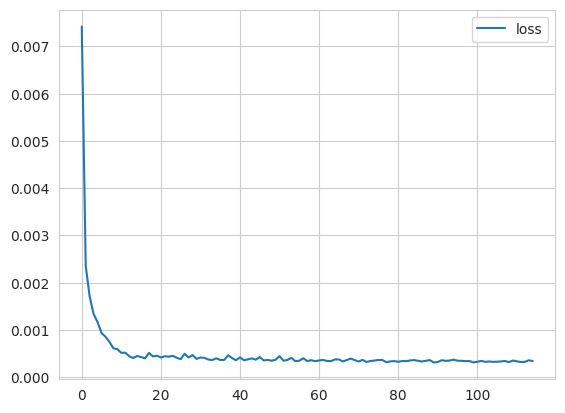

In [280]:
train_results = pd.DataFrame(results.history)
train_results.loc[:, ['loss']].plot()

RNN results do not have validation loss to check out, but from the looks of it, the training converged successfully.

#3. Testing the Results

In [302]:
df_val_scaled = df_val.copy()
df_val_scaled = pd.DataFrame(sc.fit_transform(df_val_scaled))

x_val, y_val = generate_windows(df_val_scaled)
y_predicted = rnn.predict(x_val)
y_predicted = sc.inverse_transform(y_predicted)

19/19 [==============================] - 0s 7ms/step


In [314]:
df_results = df_val[WINDOW_SIZE:].copy()
df_results['Prediction'] = y_predicted
df_results['Abs. Diff'] = abs(df_results['Adj Close'] - df_results['Prediction'])

In [315]:
df_results.head()

,Adj Close,Prediction,Abs. Diff
2364,69.998001,76.246025,6.248024
2365,71.903999,75.915581,4.011582
2366,70.444000,77.617126,7.173126
2367,70.966003,76.373535,5.407532
2368,66.608002,76.792023,10.184021


<Axes: >

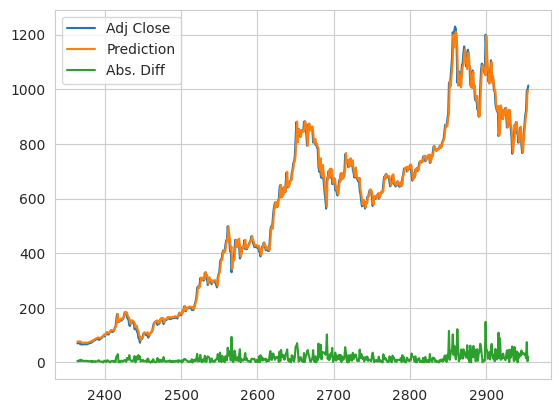

In [319]:
df_results['Adj Close'].plot(legend = True)
df_results['Prediction'].plot(legend = True)
df_results['Abs. Diff'].plot(legend = True)

In [308]:
#Very good results
from sklearn.metrics import r2_score
r2_score(df_results['Adj Close'], y_predicted)

0.9938797640109667

The final metric is 0.99 R^2, which means that the model correctly explains 99% of the variability of the data, very good results.

So, actually, there is about 30 different changes I did before this final model. I looked on other people's codes a bit so I can learn what a good RNN should be.

So there are a few things I learnt:
1. Dropout on RNN is probably not a good idea, I got stuck at 500+ loss because of it.
2. Batch Normalization Layer _is NOT_ MinMaxScaling Preprocessing, MinMaxScaling is way better.
3. Windowing the data is a good augmentation technique.

The Final Result is alright, with an R2 of 0.99 it's close to perfect.